In [3]:
""" Prova """

import xarray as xr
import netCDF4 as nc
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

import math
import matplotlib
from matplotlib import ticker
import os,sys
import matplotlib.pylab as plt

from pylab import polyfit

from IPython.display import Markdown # for color printing 

# define a function for pretty plotting 
def cprint(text, color):
    """ Nicely color-prints the text given with the color chosen """
    # see reference: https://htmlcolorcodes.com/
    dic ={ 'red'     : '#ff0000' , 'blue' : '#0000FF' , 'green':'#00FF00' ,
           'aqua'    : '#00FFFF' ,
           'fuchsia' : '#FF00FF' } # mapping nasmes to HTML color codes
    
    display (Markdown('<span style="color:' + dic[color] + '"> ' + text + '</span>'))


# variables of interest 
variables=['observation_value','date_time','z_coordinate','z_coordinate_type', 'observed_variable', 'sensor_id' , 'original_precision' , 'secondary_value' , 'value_significance']
varis = variables[:]

to_drop = ['adjustment_id', 'advanced_assimilation_feedback', 'advanced_homogenisation', 'advanced_qc', 'advanced_uncertainty', 
                      'bbox_max_latitude', 'bbox_max_longitude', 'bbox_min_latitude', 'bbox_min_longitude', 'code_table', 'conversion_flag', 'conversion_method', 
                      'crs', 'data_policy_licence', 'date_time_meaning', 'exposure_of_sensor', 'latitude', 'location_method', 'location_precision', 'longitude', 'numerical_precision', 
                      'observation_duration', 'observation_height_above_station_surface', 'observation_id', 'original_code_table', 'original_units', 'original_value', 
                      'processing_level', 'quality_flag', 'report_id', 'secondary_variable', 'sensor_automation_status', 'source_id', 'spatial_representativeness', 
                      'traceability', 'units', 'z_coordinate_method']

out_dir = 'Plots'
os.system('mkdir ' + out_dir )
os.system('mkdir ' + out_dir + '/Averages' )


month_dic = { 1 : 'January' , 2  : 'February'  , 3  : 'March'     , 4 : 'April' , 5: 'May' , 6:'June' ,
                  7 : 'July'    , 8  : 'August'    , 9  : 'September' , 
                 10 : 'October' , 11 : 'November'  , 12 : 'December'  }
    
std_plevels = [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


In [4]:
""" Load the averaged file """
dir = '/raid60/scratch/federico/CIAONE/'
f1 = '10393_monthly_averages_VARIABLE.nc'
station = '10393'

#f2 = '82930_monthly_averages_VARIABLE.nc'
#station = '82930'

average   = xr.open_dataset(dir + f1 , engine = 'h5netcdf' , group = "observations_table", decode_times = True , drop_variables= to_drop).to_dataframe()

In [5]:
def plot_series(average_df = '' , min_year = 1970, max_year = 2000 , pressure = '' , variables = [], months = ['1'] , station = '' , text = '', plot_errors = False):
    
    """ Plot the time series of the averages comprised between min_year and max_year. 
        average_df: dataframe of the observations_table """

    #print(average_df.columns) 
    
    months = range(1,13) 
    
    years = range(min_year, max_year)
    
    hour = 12
    fs   = 15
    obs_00 , obs_12, dt_12, dt_00 = [], [] , [] , []
    
    obs_00_global , obs_12_global = [] , []

    obs_00_reanalysis, obs_12_reanalysis = [] , []

    obs_00_unbiased, obs_12_unbiased = [] , []

    p = pressure
    for v in variables:
            for y in years:
                #print(y)
                for m in months:
                    #print(m)
                    if m < 10:
                        M = '0' + str(m) # correcting the month by adding a 0 
                    else:
                        M= str(m)
                        
                    ts = str(y) + '-' + M + '-01'
                    TS = np.datetime64(ts)
                    
                    red    = average_df.loc [ ( average_df['date_time'].dt.year  == y ) &    
                                          ( average_df['date_time'].dt.month == m ) & 
                                          ( average_df['observed_variable']  == v ) & 
                                          ( average_df['z_coordinate']       == p ) & 
                                          ( average_df['z_coordinate_type']  == 1 )   ]
                    
                    red_12 = red.loc [ ( red['date_time'].dt.hour  == 12 ) ]  
                    red_00 = red.loc [ ( red['date_time'].dt.hour  == 0 ) ]  

                    try:
                        value_12 = red_12['observation_value'][0]
                        obs_12.append(value_12)
                        dt_12.append(TS)
                        
                        obs_12_global    .append(red_12['observation_value_global']    [0] )
                        obs_12_reanalysis.append(red_12['observation_value_reanalysis'][0] )
                        obs_12_unbiased.append(red_12['observation_value_bias'][0] )

                        
                        '''
                                                    res[v][y][m][h]['values_global']    .append(red['observation_value_global'])
                            res[v][y][m][h]['values_reanalysis'].append(red['observation_value_reanalysis'])
                    value_global = res[85][y][m][h]['values_global']
                    value_renaalysis = res[85][y][m][h]['values_reanalysis']
                        '''
                    
                    
                    
                    
                    except:
                        pass
 
                    try:
                        value_00 = red_00['observation_value'][0]
                        obs_00.append(value_00)
                        dt_00.append(TS)
                    except:
                        pass
                    

    def plot(dt_12, value_12 , value_12_global, value_12_reanalysis , value_12_unbiased, dt_00, value_00, gloabl = True, reanalysis = True ):
        
        fig, ax = plt.subplots(figsize=(8,7) )
        # incorrect averages 
        #plt.plot    (dt_12, value_00 , label = 'h:00 ' , color = 'lime')
        #plt.scatter (dt_00, value_00 , color = 'limegreen')

        plt.plot    (dt_12, value_12            , label = 'Monthly Average '    , color = 'cyan' )
        plt.scatter (dt_12, value_12_global     , label = 'Global Average '     , color = 'red'  )
        plt.scatter (dt_12, value_12_reanalysis , label = 'Reanalysis Average ' , color = 'black')
        plt.scatter (dt_12, value_12_unbiased   , label = 'Unbiased Average '   , color = 'orange')

        
        #plt.scatter (dt_12, value_12  , color = 'slateblue')

        #plt.fill_between(dt, av-av_err, av+av_err, facecolor='orange',alpha=0.3)

            
        """ General Properties """
        
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='x'   , which='major', labelsize=15 , rotation = 45)

        
        ax.tick_params(axis='both', which='minor', labelsize=8)
        #w = ax.invert_yaxis() 
        
        ax.set_ylabel( 'Time Stamp'      , fontsize = fs )     
        ax.set_ylabel( 'Temperature [K]' , fontsize = fs )        
        ax.grid(ls =":" , color = "lightgray")   
        ax.legend(loc = 'best', fontsize = fs) 
                
        plt.title("Average Temperature h:12- Pressure = " + str(p) + ' [Pa] - Station ' + station , fontsize = fs , y = 1.02 )
    
        plt.show()    
        plt.savefig(out_dir + '/Averages/' + station + '_Temp_averages.png' ,   bbox_inches = 'tight' , dpi = 200 )
        plt.close()        
        
    #print( dt_12, obs_12 )
    try:
        0
        #ff = plot(dt_12, obs_12, obs_12_global, obs_12_reanalysis, dt_00, obs_00 )
    except:
        print(' Data for pressure ' , p , ' is not available ')
    ff = plot(dt_12, obs_12, obs_12_global, obs_12_reanalysis, obs_12_unbiased, dt_00, obs_00 )

    # dates = date range 
    

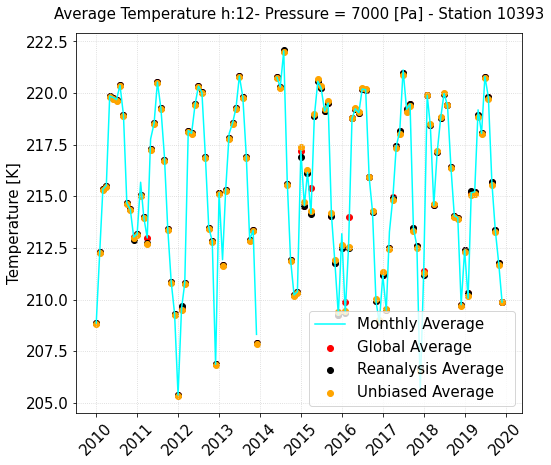

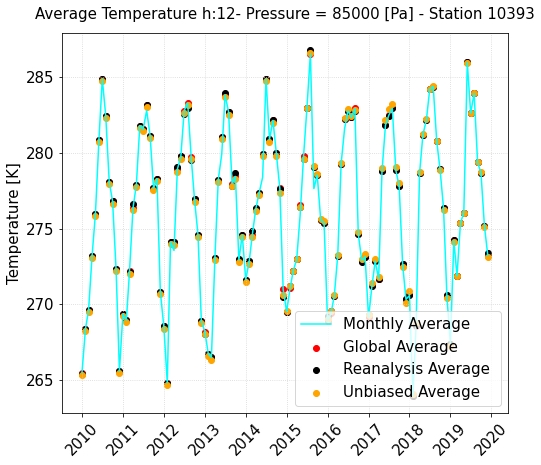

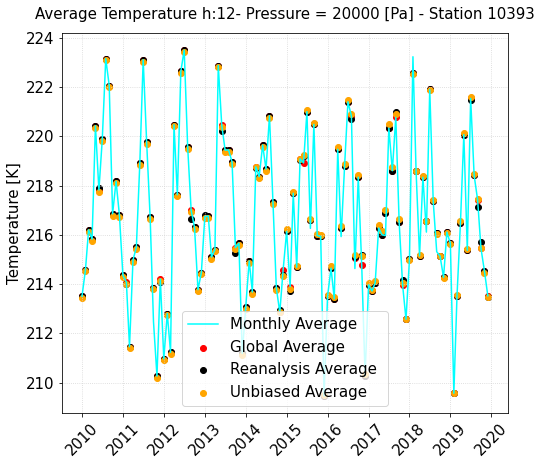

In [6]:
for p in [7000, 85000, 20000 ]:
    pp = plot_series(average_df = average, min_year = 2010, max_year = 2020 , pressure = p , variables = [85] , station = station, plot_errors = False )

In [7]:
"""
Index(['date_time', 'observation_value', 'observation_value_global',
       'observation_value_reanalysis', 'observed_variable',
       'original_precision', 'original_precision_global',
       'original_precision_reanalysis', 'secondary_value',
       'secondary_value_global', 'secondary_value_reanalysis', 'sensor_id',
       'value_significance', 'z_coordinate', 'z_coordinate_type'],
      dtype='object')"""

"\nIndex(['date_time', 'observation_value', 'observation_value_global',\n       'observation_value_reanalysis', 'observed_variable',\n       'original_precision', 'original_precision_global',\n       'original_precision_reanalysis', 'secondary_value',\n       'secondary_value_global', 'secondary_value_reanalysis', 'sensor_id',\n       'value_significance', 'z_coordinate', 'z_coordinate_type'],\n      dtype='object')"

## MEANING OF THE VARIABLE
### **Monthly Average** = outliers were taken out considering only each month data
### **Global Average** = outliers were taken out considering all available data, per each month 
### **Reanalysis Average** = outliers were taken out considering reanalysis data (if reana was outlier, data point was removed) 
---

In [8]:
def profile_per_month_and_year(average_df = average , min_year = 1970, max_year = 1990 , variables = [85] , station = station , text = '' ):
    """ This function plots the profile of the sonde for each available month and year in the date years range specified, for the available stadard p levels"""
    
    months = range(1,12+1) 
    years = range(min_year, max_year+1)
    
    fs = 15
    obs_00 , obs_12, dt_12, dt_00 = [], [] , [] , []
    
    '''
    month_dic = { 1 : 'January' , 2  : 'February'  , 3  : 'March'     , 4 : 'April' , 5: 'May' , 6:'June' ,
                  7 : 'July'    , 8  : 'August'    , 9  : 'September' , 
                 10 : 'October' , 11 : 'November'  , 12 : 'December'  }
    '''
    
    """ Fill the res dictionary with the temp-pressure profiles for each month and year """
    res = {}
    for v in variables:
        res[v] = {}
        for y in years:
            res[v][y] = {}
            for m in months:
                res[v][y][m] = {}
                for h in [0,12]:
                    res[v][y][m][h] = {}
                    res[v][y][m][h]['pressure'] = []
                    res[v][y][m][h]['values']   = []

                    for p in std_plevels:

                        red    = average_df.loc [ ( average_df['date_time'].dt.year   == y ) &    
                                                  ( average_df['date_time'].dt.month  == m ) & 
                                                  ( average_df['date_time'].dt.hour   == h ) & 
                                                  ( average_df['observed_variable']   == v ) & 
                                                  ( average_df['z_coordinate']        == p ) & 
                                                  ( average_df['z_coordinate_type']   == 1 )   ]
                                            
                        try:
                            value = red['observation_value'][0]
                            res[v][y][m][h]['pressure'].append(p)
                            res[v][y][m][h]['values']  .append(value)


                        except:
                            pass
 

    for m in months:
        fig, ax = plt.subplots(figsize=(8,7) )
        
        found = False
        for h in [12]:
            for y in years:
                #for h in [0,12]:
                    value = res[85][y][m][h]['values']

                    
                    press = res[85][y][m][h]['pressure']
                
                    if len( [ v for v in value if not np.isnan(v) ] ) >1:
                        found = True
                        plt.plot    (value, [p/100 for p in press] , label = str(y) )
                        plt.scatter (value, [p/100 for p in press]   )


                    else:
                        continue
        if found:
            """ Plot properties """
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.tick_params(axis='both', which='minor', labelsize=8)
            w = ax.invert_yaxis() 
            ax.set_ylabel( 'Pressure [hPa]'  , fontsize = fs )     
            ax.set_xlabel( 'Temperature [K]' , fontsize = fs )        
            ax.grid(ls =":" , color = "lightgray")   
            ax.legend(loc = 'upper right', fontsize = fs-2 , ncol = 2) 
            
            plt.title("Average Temperature h:12 - " + month_dic[m] , fontsize = fs , y = 1.02 )

            plt.show()    
            plt.savefig(out_dir + '/Averages/' + station + '_Temp_averages_month_' + str(m) + ' ' + text + '.png' ,   bbox_inches = 'tight' , dpi = 200 )
            plt.close()    
                
        

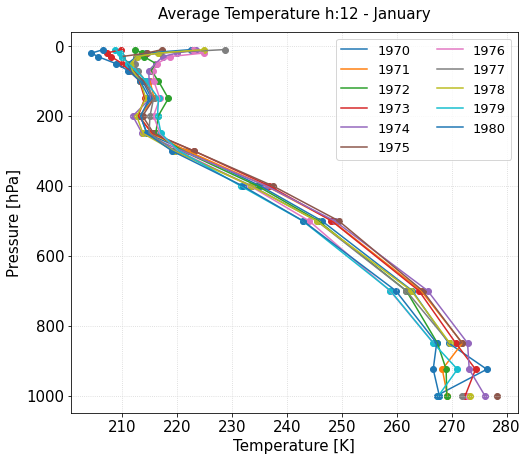

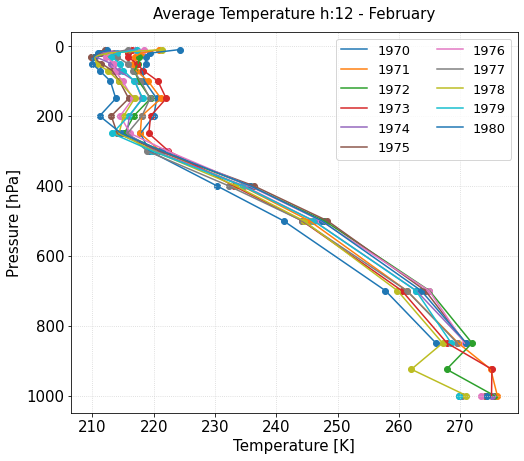

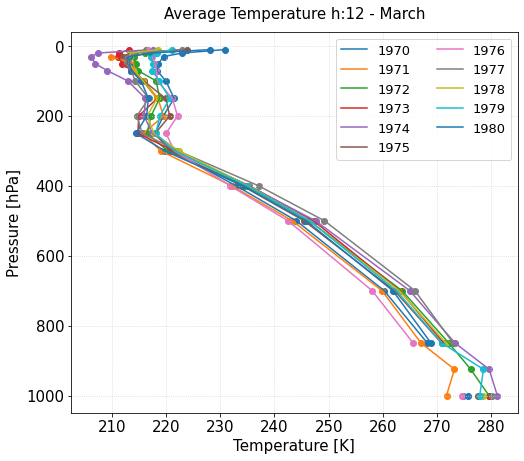

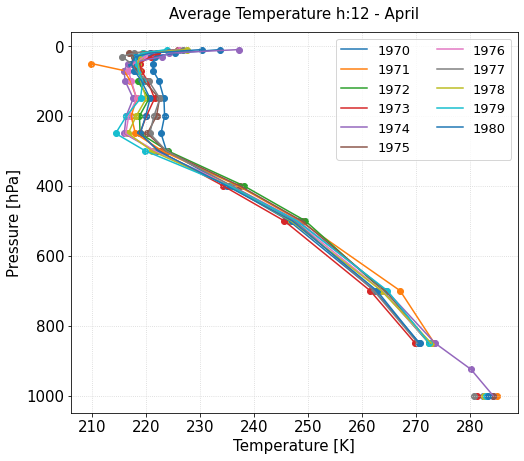

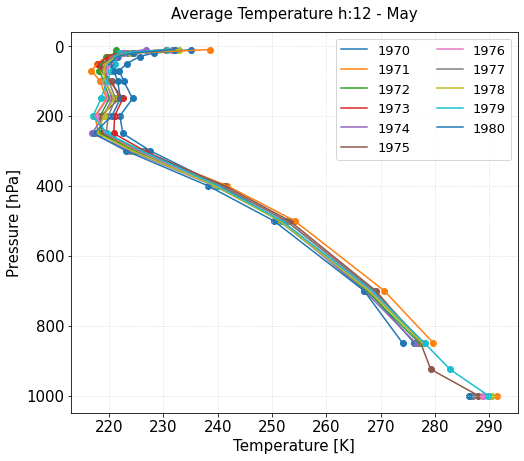

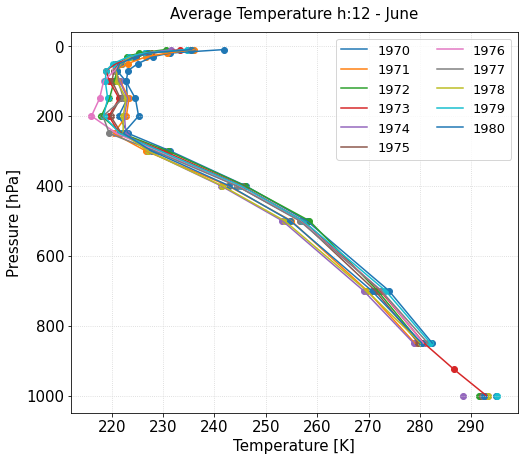

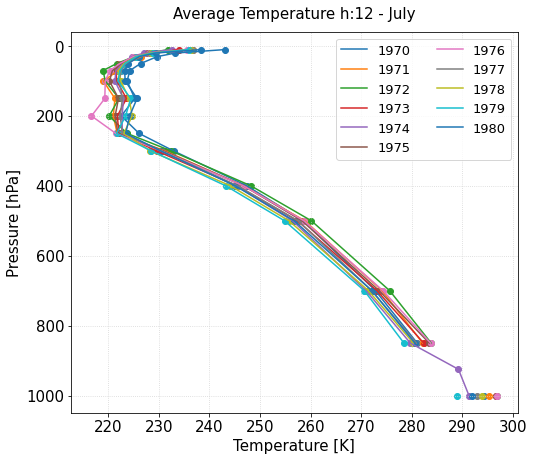

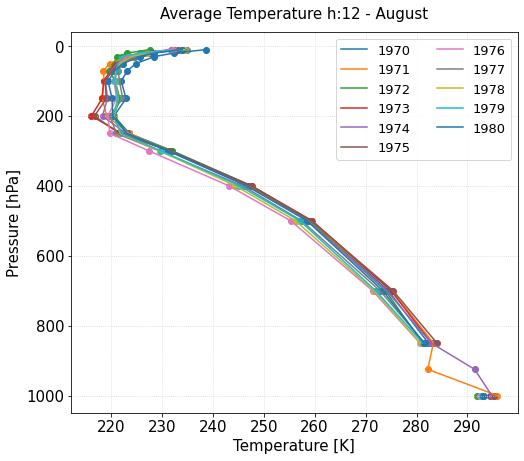

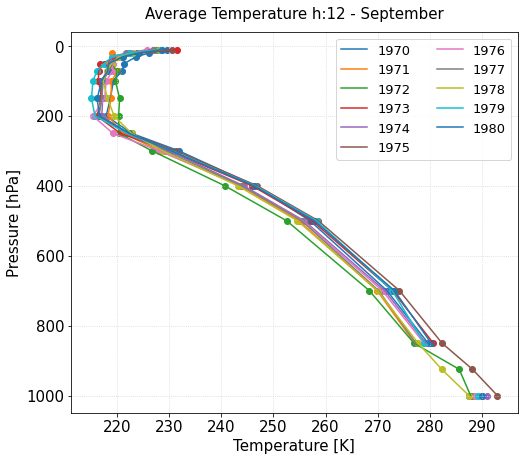

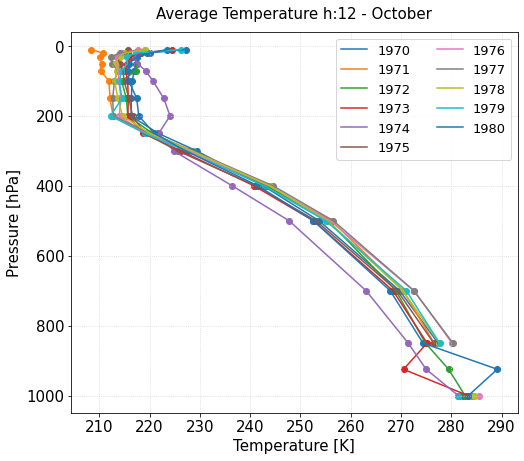

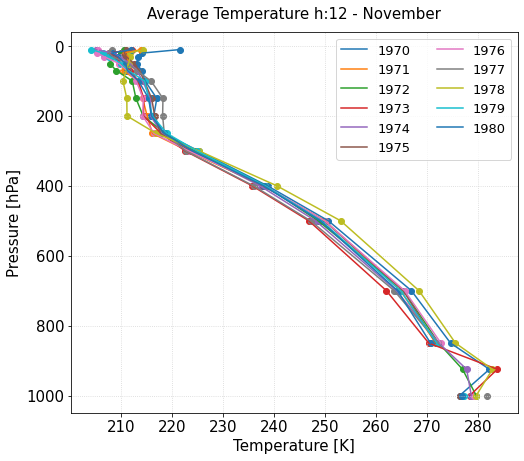

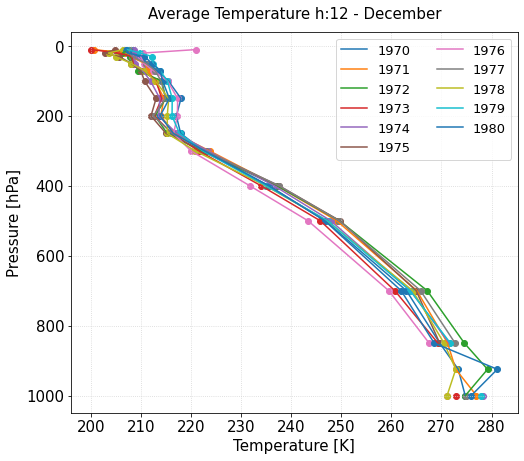

In [9]:
a = profile_per_month_and_year(average_df = average , min_year = 1970, max_year = 1980 , variables = [85] , station = station , text='_1970-1980' )


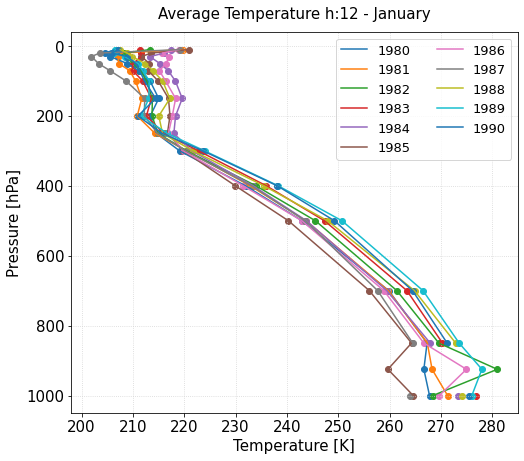

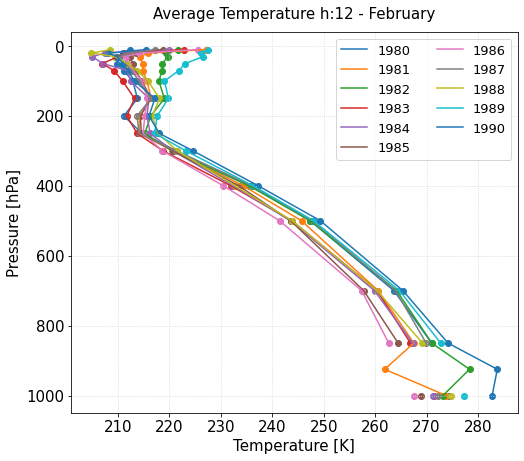

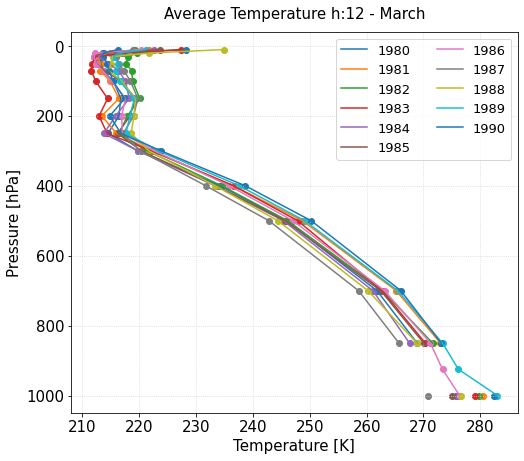

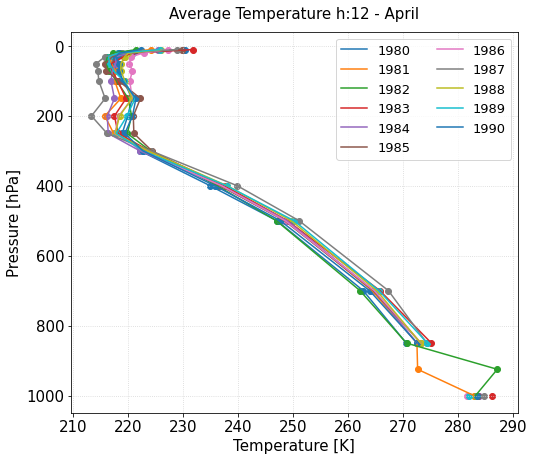

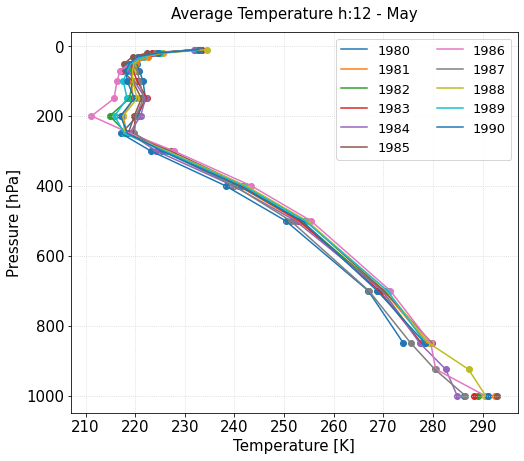

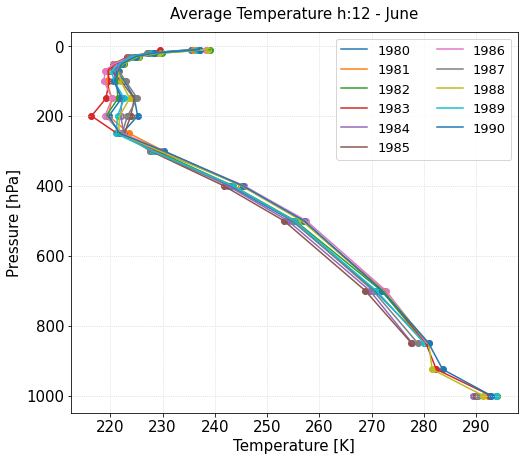

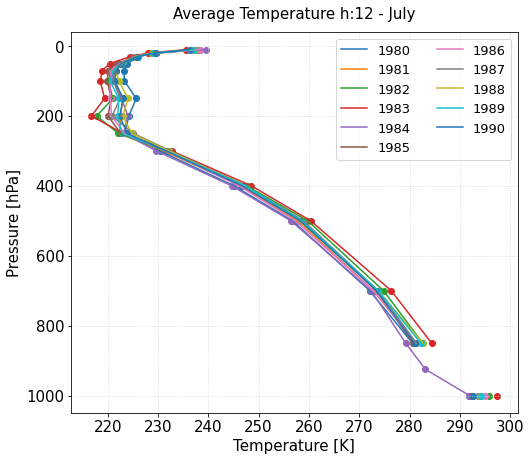

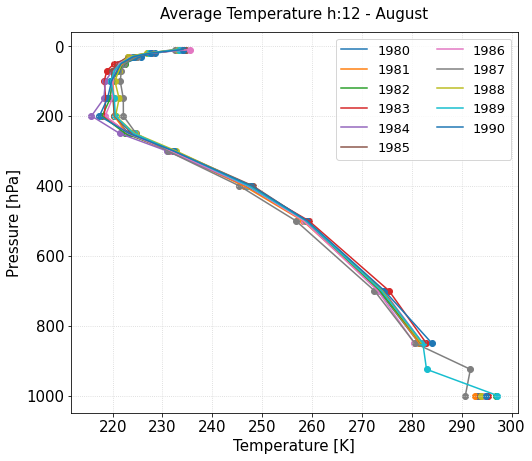

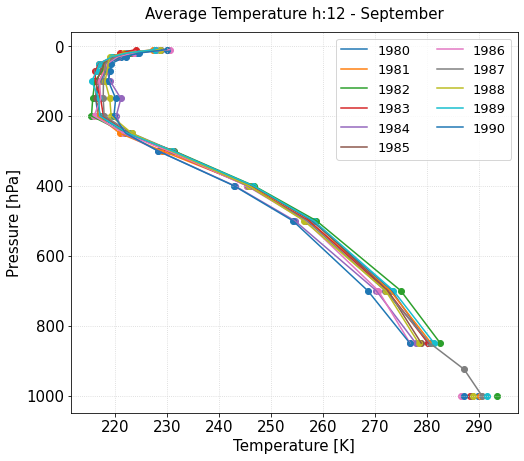

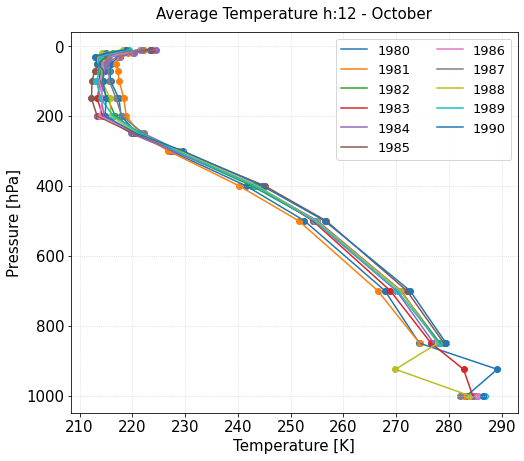

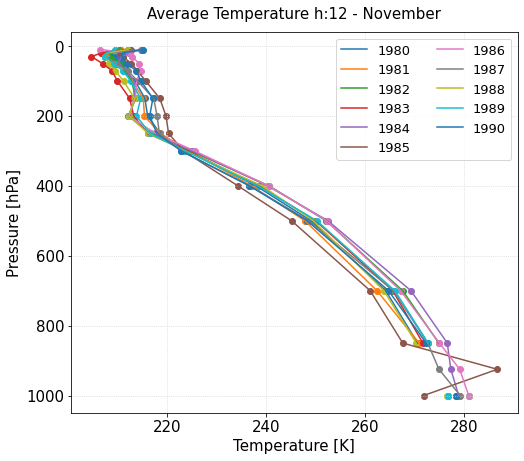

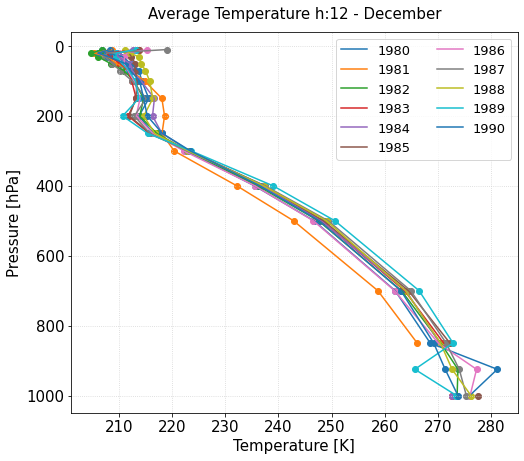

In [10]:
a = profile_per_month_and_year(average_df = average , min_year = 1980, max_year = 1990 , variables = [85] , station = station , text='_1980-1990' )


In [11]:
def plot_climate_change(average_df = '' , min_year = 1970, max_year = 2000 , pressure = '' , variables = [], month = 1 , station = '' , text = '' ):
    
    """ Plot the time series of the averages comprised between min_year and max_year. 
        average_df: dataframe of the observations_table """

    years = range(min_year, max_year)
    
    hour = 12
    fs = 15
    obs_00 , obs_12, dt_12, dt_00 = [], [] , [] , []
    obs_bias_12 = []
    
    
    p = pressure
    
    m = month
    
    for v in variables:
            for y in years:

                    if m < 10:
                        M = '0' + str(m) # correcting the month by adding a 0 
                    else:
                        M= str(m)
                        
                    ts = str(y) + '-' + M + '-01'
                    TS = np.datetime64(ts)
                    
                    red = average_df.loc [ ( average_df['date_time'].dt.year  == y ) &    
                                          ( average_df['date_time'].dt.month == m ) & 
                                          ( average_df['observed_variable']  == v ) & 
                                          ( average_df['z_coordinate']       == p ) & 
                                          ( average_df['z_coordinate_type']  == 1 )   ]
                    
                    red_12 = red.loc [ ( red['date_time'].dt.hour  == 12 ) ]  
                    red_00 = red.loc [ ( red['date_time'].dt.hour  == 0 ) ]  

                    try:
                        value_12 = red_12['observation_value_global'][0]
                        obs_12.append(value_12)
                        obs_bias_12.append(red_12['observation_value_bias'][0])
                        dt_12.append(TS)
                    except:
                        pass
 
                    try:
                        value_00 = red_00['observation_value'][0]
                        obs_00.append(value_00)
                        dt_00.append(TS)
                    except:
                        pass
                    

    def plot(dt_12, value_12 , value_bias_12, dt_00, value_00):
        
        fig, ax = plt.subplots(figsize=(8,7) )
        # incorrect averages 
        #plt.plot    (dt_00, value_00 , label = 'h: 00:00 ' , color = 'lime')
        #plt.scatter (dt_00, value_00 , color = 'limegreen')

        #m,b = np.polyfit(x, y, 1)

        if len(  [ v for v in value_12 if not np.isnan(v)] ) >0:
            plt.scatter    (dt_12, value_12 , color = 'orange' , label = 'Biased')
            plt.plot    (dt_12, value_12 , color = 'red' )

        #m,b = np.polyfit(dt_12, value_12, 1)
            plt.scatter    (dt_12, value_bias_12 , color = 'cyan' , label = 'Unbiased ERA5')
            plt.plot    (dt_12, value_bias_12 , color = 'blue' ,)

        #plt.plot    (dt_12, dt_12*m+b , color = 'red' , ls = '--' )

        #plt.scatter (dt_12, value_12 , color = 'red')

        #plt.fill_between(dt, av-av_err, av+av_err, facecolor='orange',alpha=0.3)

            
            """ General Properties """
        
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.tick_params(axis='x'   , which='major', labelsize=15 , rotation = 45)

        
            ax.tick_params(axis='both', which='minor', labelsize=8)
            #w = ax.invert_yaxis() 
        
            ax.set_ylabel( 'Time Stamp'      , fontsize = fs )     
            ax.set_ylabel( 'Temperature [K]' , fontsize = fs )    
            ax.set_ylim( 160 , 300 )     

            ax.grid(ls =":" , color = "lightgray")   
            ax.legend(loc = 'best', fontsize = fs) 
                
            #plt.title("Pressure = " + str(p) + ' [Pa] - Station - ' + station + ' - ' + month_dic[m] , fontsize = fs , y = 1.02 )
            plt.title("h:12 - Pressure = " + str(p) + ' [Pa] - Station: ' + station + ' - ' + month_dic[m] , fontsize = fs , y = 1.02 )

            plt.show()    
            plt.savefig(out_dir + '/Averages/' + station + '_averages_' + month_dic[m] + '_pressure_' + str(p) + '.png' ,   bbox_inches = 'tight' , dpi = 200 )
            plt.close()        
        
    #print( dt_12, obs_12 )
    #try:
    #    ff = plot(dt_12, obs_12, dt_00, obs_00 )
    #except:
    #    print(' Data for pressure ' , p , ' month ' , m , '  is not available ')
        
    ff = plot(dt_12, obs_12, obs_bias_12, dt_00, obs_00 )

    # dates = date range 
    

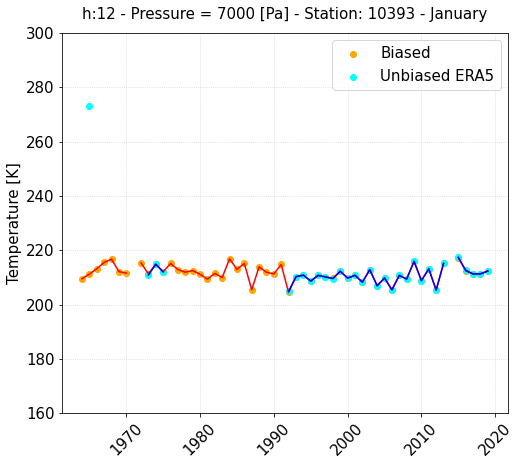

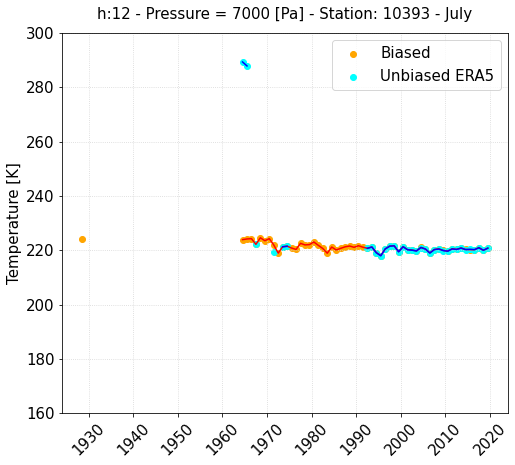

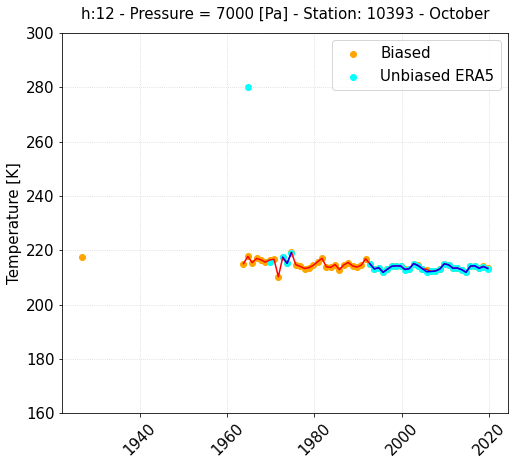

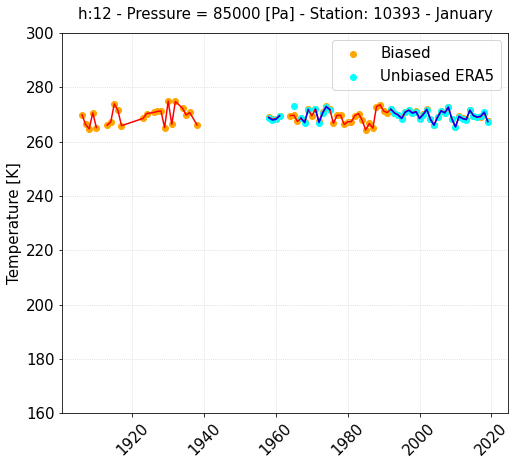

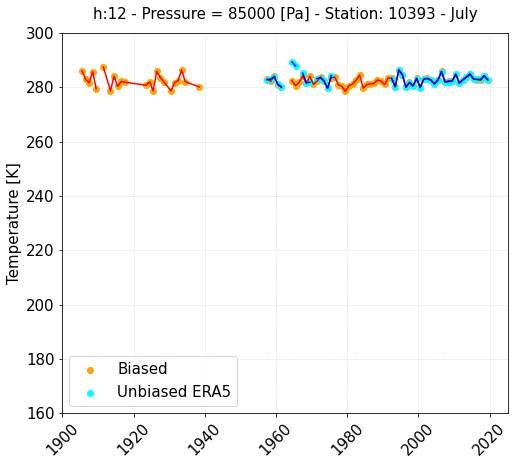

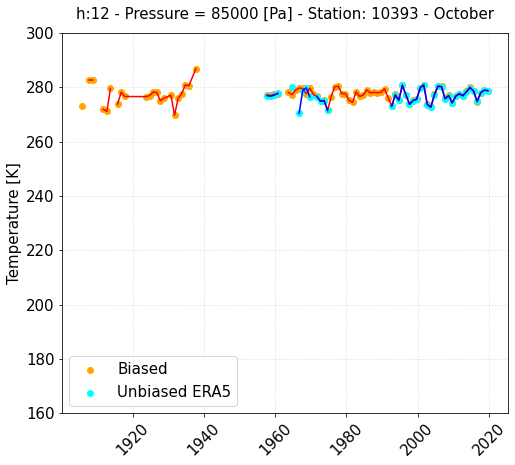

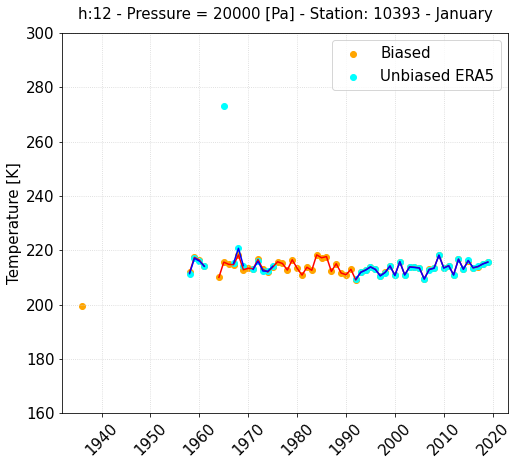

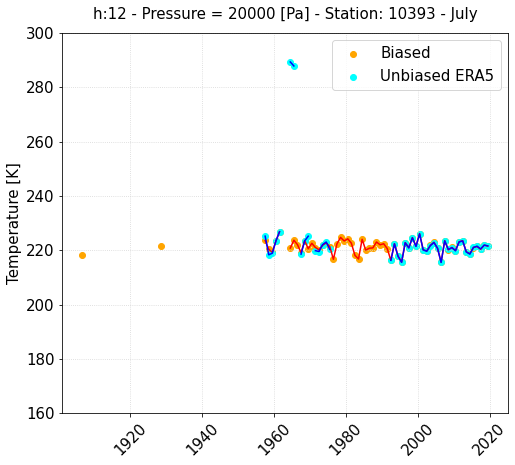

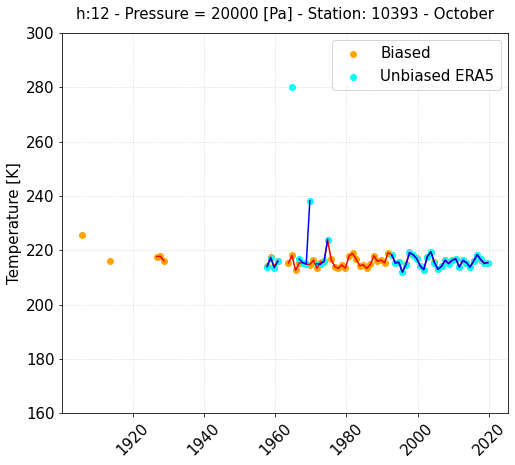

In [12]:
for p in [7000, 85000, 20000 ]:
    for m in [1, 7, 10 ]:
        pp = plot_climate_change(average_df = average, min_year = 1900, max_year = 2020 , pressure = p , variables = [85] , month = m,  station = station )